## Define the case we want to consider
In the next code block, we select the mechanism (Li-Dryer for hydrogen combustion) and set the inlet temperature, the pressure and the equivalence ratio `phi`. The function  
`g.set_equivalence_ratio(...)`  
takes as input the `phi`, the fuel composition, and the oxidizer composition.
Then the code prints some overview of what you have initialized.

# Computing autoignition flame profile with Cantera, with export to PeleC and S3D

## Background
You should have installed Cantera, either from Anaconda or from source.
If you are compiling Cantera from source, you need to have installed
    * Boost
    * Scons
    * Cython
    * Python 3 with Numpy
Then you need to clone Cantera from the repo:   
`git clone https://github.com/Cantera/cantera.git`  
and then you need to edit the `cantera.conf` file, which is empty, and add the line   
`python_package = 'y'`  
such that it will build the Python interface.  
Following these commands, you can build Cantera using the commands  
`scons build`  
`sudo scons install`  
where the build step may take a couple of hours, depending on your hardware.  
Test that your install is working by running `python` in your terminal, and do  
`>>> import cantera as ct`  
`>>> gas = ct.Solution('gri30.xml')`
`>>> gas()`  
which should print some default temperature, pressure, density etc. for the GRI 30 mechanism.

## Importing the packages required, setting some plot style defaults

In [1]:
import sys, os
import cantera as ct
import numpy as np
import pandas as pd
import scipy.interpolate
%matplotlib notebook
import matplotlib.pylab as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.figsize'] = (8,6)
# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['figure.autolayout'] = True

In [2]:
# For pure hydrogen:
g = ct.Solution('LiDryer_H2.cti')
T_init = 1100
P_init = 1.0
g.TP = T_init, P_init*ct.one_atm
phi=0.35
#g.X = 'H2:0.00811, O2:0.18316, N2:0.75691, H2O:0.05182'
#print(g.get_equivalence_ratio('O2'))
g.set_equivalence_ratio(phi, {'H2':1}, {'O2':0.14440, 'N2':0.68155, 'H2O':0.07256})
g()
g.net_rates_of_progress
[s.name for s in g.species()]



  gas:

       temperature            1100  K
          pressure          101325  Pa
           density        0.279566  kg/m^3
  mean mol. weight         25.2345  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      3.0563e+05        7.712e+06     J
   internal energy          -56810       -1.434e+06     J
           entropy          9336.2        2.356e+05     J/K
    Gibbs function     -9.9642e+06       -2.514e+08     J
 heat capacity c_p          1345.9        3.396e+04     J/K
 heat capacity c_v          1016.4        2.565e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                H2       0.101121       0.00807817         -20.0259
                O2       0.144459         0.183183         -28.7564
               H2O      0.0725898        0.0518229         -54.2257
                N2        0.

['H2', 'O2', 'O', 'OH', 'H2O', 'H', 'HO2', 'H2O2', 'N2']

## Set up Cantera to solve for the flame
Cantera needs a few parameters to be set in order to solve for the flame.
Note that for autoignition, the flame speed is arbitrary. So Cantera will find a solution at some random speed, corresponding to some random flame length (domain width). We will normalize the spatial coordinate by the speed it finds, giving us a solution as function of the residence time, which makes physical sense. Then subsequently we can map this to a CFD case by making a 1D domain for the flame that corresponds to the inlet velocity selected in CFD.

In [3]:
width = 0.014 # Initial guess for domain width in metres, will be automatically refined
flame = ct.FreeFlame(g, width=width)
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)
loglevel = 1
flame.solve(loglevel=loglevel, auto=True)
Su0 = flame.u[0]
print(" \n\nFlame Speed is: {:.2f} cm/s".format(Su0*100))



************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     6.328e-06      6.859
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     7.208e-05      3.161
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accomodate flame thickness. New width: 0.028 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 7 
    to resolve H H2 H2O H2O2 HO2 N2 O O2 OH T u 
##############################################################################

*********** Solving on 17 point grid with energy equation enabled ************

..............................................................................
Attempt 

## Plot the results from Cantera
We make a "time grid" that has units milliseconds, interpreted as the residence time, and then plot the temperature against this.  
Then we plot the concentration of H$_2$, H$_2$O and the radical HO$_2$ against residence time.  
Finally, we plot the velocity and the density against residence time.

<IPython.core.display.Javascript object>


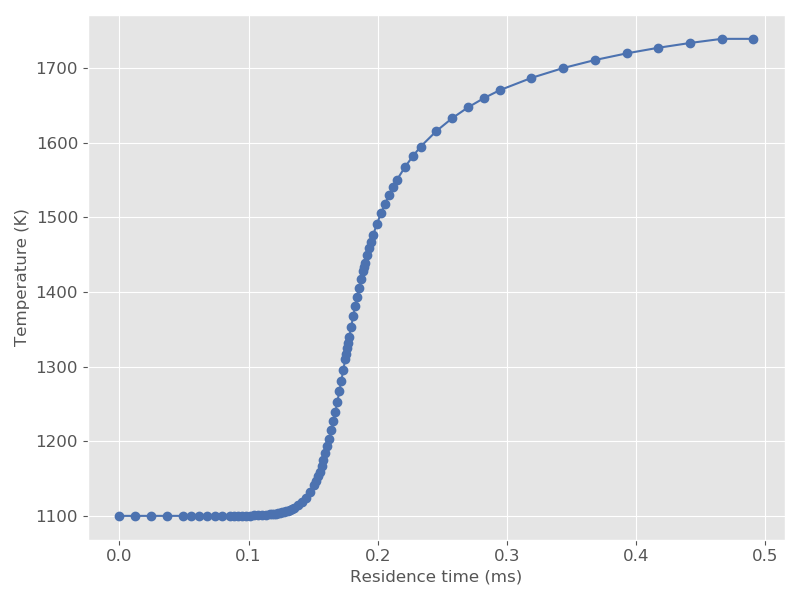

In [4]:
plt.figure()
time_grid = 1000*flame.grid/Su0
plt.plot(time_grid, flame.T, '-o')
plt.xlabel('Residence time (ms)')
plt.ylabel('Temperature (K)');

<IPython.core.display.Javascript object>


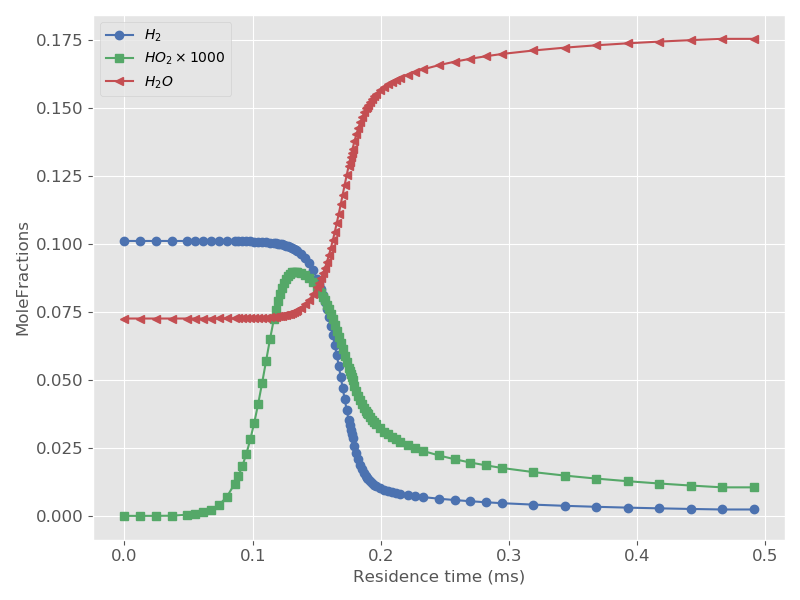

In [5]:
species_dict = {}
for i, specie in enumerate(g.species()):
    species_dict[specie.name] = i
X_H2  = flame.X[species_dict['H2']]
X_HO2 = flame.X[species_dict['HO2']]
X_H2O = flame.X[species_dict['H2O']]

plt.figure()

plt.plot(time_grid, X_H2,  '-o', label=r'$H_{2}$')
plt.plot(time_grid, X_HO2*1000, '-s', label=r'$HO_{2} \times 1000$')
plt.plot(time_grid, X_H2O, '-<', label=r'$H_{2}O$')

plt.legend(loc=2)
plt.xlabel('Residence time (ms)')
plt.ylabel('MoleFractions');

<IPython.core.display.Javascript object>


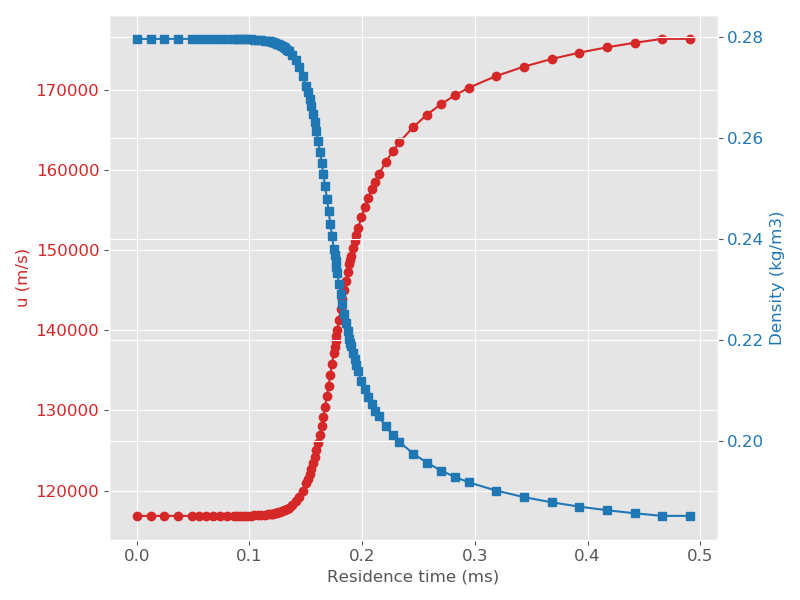

In [6]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Residence time (ms)')
ax1.set_ylabel('u (m/s)', color=color)
ax1.plot(time_grid, flame.u,  '-o', color=color, label=r'$u$')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Density (kg/m3)', color=color)
plt.plot(time_grid, flame.density, '-s', color=color, label=r'$\rho$')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()


## Output to files that can be read by PeleC and by S3D
Here we output two files that can be used as input for PeleC and for S3D, respectively.

PeleC needs the input as function of the length along the domain. Thus for PeleC we need the inlet speed to convert our residence time flame to the appropriate spatial length.

S3D needs the input as a function of the progress variable. This is just 0 at the first `flame.grid` point, and 1 at the last point. Thus we do not need any inlet speed for generating the S3D file.

In [7]:
# Take the computed autoignition flame, rescale it to fit the inlet velocity set in PeleC, and write to a .dat file
# that PeleC can read to initialize the flame.
# Note that PeleC uses cgs units, so we do the conversion before output.
inlet_speed = 200.0 # inlet speed  in PeleC, in m/s

pele_grid = flame.grid*inlet_speed/Su0*1e2 # cm
with open("H2-autoignition-LiDryer-pelec-T_"+str(T_init)+"-P_"+str(P_init)+"-phi_"+str(phi)+".dat","w") as f:
    field_list = ["X", "temp", "u", "rho"] + list(species_dict.keys())
    f.write('VARIABLES='+' '.join(['"'+f+'"' for f in field_list]) + '\n')
    f.write('ZONE I='+str(len(pele_grid))+' F=POINT\n')
    for i, x in enumerate(pele_grid):
        values_list = [ x, flame.T[i], flame.u[i]*inlet_speed/Su0*1e2, flame.density[i]/1e3 ]
        for k,v in species_dict.items():
            values_list += [flame.X[v][i]]
        f.write(" ".join([str(v) for v in values_list]) + "\n")

# The S3D "grid" is in progress variable, which just goes from 0 to 1, so does not require knowledge of the inlet speed
# However, S3D needs a uniform grid in progress variable, so we need to interpolate everything over to this. The code below
# uses the griddata routine from Scipy which does exactly this.
X_N = len(species_dict.keys())
s3d_Npoints = 200
s3d_grid = np.linspace(0,1,s3d_Npoints)
T_grid = (flame.T - flame.T[0])/(flame.T[-1] - flame.T[0])
s3d_T = scipy.interpolate.griddata(T_grid, flame.T, s3d_grid, method='linear')
s3d_Y = np.zeros((X_N,s3d_Npoints))
for i in range(X_N):
    s3d_Y[i,:] = scipy.interpolate.griddata(T_grid, flame.Y[i], s3d_grid, method='linear')
with open("H2-autoignition-LiDryer-S3D-T_"+str(T_init)+"-P_"+str(P_init)+"-phi_"+str(phi)+".dat","w") as f:
    f.write(" Progress variable table of temperature and species from Cantera\n")
    f.write(" rows 1 and 2: number of entries, c max and c min\n")
    f.write(" remaining rows: column 1: temp, column 2 -> nspec+1 : species\n")
    f.write(' {:12d}\n'.format(s3d_Npoints))
    f.write(' {:18.14E}     {:18.14E}\n'.format(1.0,0.0))
    for i, x in enumerate(s3d_grid):
        values_list = [s3d_T[i]]
        for k,v in species_dict.items():
            values_list += [s3d_Y[v][i]]
        f.write(' '+' '.join(['{:10.8E}'.format(v) for v in values_list])+"\n")
print("Successfully saved files to the folder "+os.getcwd())


Successfully saved files to the folder /Users/andreag/Applications/Numerical_Simulations/Cantera
